### RNAPuzzle test

In [1]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")

In [2]:
import torch
import torch.nn as nn
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDataset
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader
from numpy import inf
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from Bio import PDB

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def spearman(predictions, targets):


    n = len(predictions.view(-1))

    # Calculate the differences between rankings
    d = torch.argsort(targets.view(-1), dim=-1)-torch.argsort(predictions.view(-1), dim=-1)

    # Square the differences
    d_squared = d ** 2

    # Sum the squared differences
    d_squared_sum = torch.sum(d_squared)

    # Calculate Spearman correlation coefficient
    # Formula: ρ = 1 - (6 * Σd² / (n * (n² - 1)))
    
    return 1 - (6 * d_squared_sum) / (n * (n**2 - 1))



class SpearmanLoss(nn.Module):
    def __init__(self, regularization_weight=0.1):
        super(SpearmanLoss, self).__init__()
        self.regularization_weight = regularization_weight

    def forward(self, predictions, targets):
        # Standard loss component (e.g., MAE)
        mae_loss =  (torch.abs(predictions - targets)).mean()
        
        # Soft rank correlation component

        # Overall loss: combine MSE and negative correlation 
        # (we negate correlation because we want to maximize it)
        loss = (
            1 - self.regularization_weight
        ) * mae_loss - self.regularization_weight * spearman(predictions, targets)

        return loss
    
    def _soft_rank(self, x):
        """Soft rank function using pairwise comparisons"""
        n = x.size(0)
        # Create a matrix where each entry (i,j) compares x[i] > x[j]
        diff = x.unsqueeze(0) - x.unsqueeze(1)
        # Convert differences to probabilities with sigmoid
        prob_greater = torch.sigmoid(diff * 10)  # Temperature scaling for sharper transitions
        # Sum across rows to get soft ranks
        soft_ranks = prob_greater.sum(dim=1)
        return soft_ranks



class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features, number_of_node_features, heads=4, edge_dim=36
        )

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=36
        )
        self.GATconv3 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=36
        )

        self.GCN2Conv1 = gnn.GeneralConv(
            number_of_node_features * 4, number_of_node_features, in_edge_channels=36
        )

        self.fc1 = nn.Linear(number_of_node_features, number_of_node_features)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU()
        self.activationlast = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features, dropout=0.3, layer_norm=True
        )
        self.criterion = SpearmanLoss(regularization_weight=0.5)

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv3(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.aggregation(y, batch)

        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.fc3(y)

        return self.activationlast(y)

    def training_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)

        loss_corr = self.criterion(result, data.y.unsqueeze(-1))
        loss_mae = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("train_spearman_loss", loss_corr, batch_size=125)
        self.log(
            "train_spearman", spearman(result, data.y.unsqueeze(-1)), batch_size=125
        )
        self.log("train_loss_mae", loss_mae, batch_size=125)
        self.log("train_loss_mse", loss_mse, batch_size=125)
        return loss_corr

    def validation_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)
        loss_corr = self.criterion(result, data.y.unsqueeze(-1))
        loss_mae = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("val_spearman_loss", loss_corr, batch_size=125)
        self.log("val_spearman", spearman(result, data.y.unsqueeze(-1)), batch_size=125)
        self.log("val_loss_mae", loss_mae, batch_size=125)
        self.log("val_loss_mse", loss_mse, batch_size=125)
        return loss_corr

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [4]:
dataset_test = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/PZ04/test"
)

In [6]:
dataset_test.print_summary()

RNAQuANetDataset (#graphs=84):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       55 |    755.3 |
| std        |        0 |     78.4 |
| min        |       55 |    586   |
| quantile25 |       55 |    698   |
| median     |       55 |    752   |
| quantile75 |       55 |    816   |
| max        |       55 |    942   |
+------------+----------+----------+


In [5]:
model = RNAQuANet(dataset_test[0].x.shape[1])

In [32]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-rnaquanet_dataset__all/265909920503864411/8f64edd44d4e4b3c855f83aca8765e90/checkpoints/epoch=53-step=2592.ckpt'


dataset='RNAQuANet'

In [20]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet_transformer_ares_dataset__all/306037256498709437/ea35e4e61ff147fcbdb2c0da91520616/checkpoints/epoch=29-step=1680.ckpt'
dataset='ARES'

In [11]:
best_model_path=    '/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/d27427a3cab649fb836d3ca9620b46d0/checkpoints/epoch=27-step=8596.ckpt'


dataset='LOCIPARSE'

In [33]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    best_model_path,
    number_of_node_features=dataset_test[0].x.shape[1],strict=False
)
val_model=val_model.eval()
res_inter = []
for n,i in enumerate(dataset_test):
    res_inter.append(
        [
            i.x.shape[0],
            float(val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
            ),
            dataset_test.structures[n].split('.')[0]
        ]
    )
df = pd.DataFrame(np.array(res_inter), columns=["length", "error",'name'])
# fig, ax = plt.subplots(figsize=(25, 10))

# df.boxplot(column="error", by="length", ax=ax)
# ax.set_xlabel("structure length")
# ax.set_ylabel("error")
# ax.set_title("Error distribution by sequence length on validation set")
# plt.tight_layout()

# plt.show()

# fig, ax = plt.subplots(figsize=(25, 10))
# df.groupby("length").mean().plot(kind="bar", ax=ax)
# ax.set_xlabel("structure length")
# ax.set_ylabel("mean error")
# ax.set_title("Mean error by sequence length on validation set")
# plt.show()

# fig, ax = plt.subplots(figsize=(25, 10))
# df.groupby("length").count().plot(kind="bar", ax=ax)

# ax.set_xlabel("structure length")
# ax.set_ylabel("cardinality")
# ax.set_title("Cardinality by sequence length on validation set")
# plt.show()



/tmp/ipykernel_374333/748329506.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()


In [21]:
res_inter

[[126, 4.419405460357666, '4_adamiak_4_rpr'],
 [126, 12.860881805419922, '4_chen_4_rpr'],
 [126, 13.618197441101074, '4_major_1_rpr'],
 [126, 13.398118019104004, '4_chen_7_rpr'],
 [126, 13.355815887451172, '4_chen_1_rpr'],
 [126, 13.23359203338623, '4_bujnicki_1_rpr'],
 [126, 13.527013778686523, '4_dokholyan_2_rpr'],
 [126, 13.121414184570312, '4_chen_10_rpr'],
 [126, 13.330896377563477, '4_chen_8_rpr'],
 [126, 11.855752944946289, '4_das_2_rpr'],
 [126, 3.6458590030670166, '4_adamiak_2_rpr'],
 [126, 4.315106391906738, '4_adamiak_1_rpr'],
 [126, 13.388824462890625, '4_chen_5_rpr'],
 [126, 13.23099136352539, '4_bujnicki_3_rpr'],
 [126, 12.852176666259766, '4_chen_9_rpr'],
 [126, 13.527013778686523, '4_dokholyan_1_rpr'],
 [126, 11.904082298278809, '4_santalucia_1_rpr'],
 [126, 3.843055009841919, '4_adamiak_5_rpr'],
 [126, 13.607942581176758, '4_bujnicki_5_rpr'],
 [126, 11.505133628845215, '4_das_4_rpr'],
 [126, 11.874746322631836, '4_das_1_rpr'],
 [126, 3.5756356716156006, '4_adamiak_3_rp

In [22]:
import json
import tempfile
import requests


non_standard=[ 'A23', 'A2L', 'A2M', 'A39', 'A3P', 'A44', 'A5O', 'A6A', 'A7E', 'A9Z', 'ADI', 'ADP', 'AET', 'AMD', 'AMO', 'AP7', 'AVC', 'MA6', 'MAD', 'MGQ', 'MIA', 'MTU', 'M7A', '26A', '2MA', '6IA', '6MA', '6MC', '6MP', '6MT', '6MZ', '6NW', 'F3N', 'N79', 'RIA', 'V3L', 'ZAD', '31H', '31M', '7AT', 'O2Z', 'SRA', '00A', '45A', '8AN', 'LCA', 'P5P', 'PPU', 'PR5', 'PU', 'T6A', 'TBN', 'TXD', 'TXP', '12A', '1MA', '5FA', 'A6G', 'E6G', 'E7G', 'EQ4', 'IG', 'IMP', 'M2G', 'MGT', 'MGV', 'MHG', 'QUO', 'YG', 'YYG', '23G', '2EG', '2MG', '2SG', 'B8K', 'B8W', 'B9B', 'BGH', 'N6G', 'RFJ', 'ZGU', '7MG', 'CG1', 'G1G', 'G25', 'G2L', 'G46', 'G48', 'G7M', 'GAO', 'GDO', 'GDP', 'GH3', 'GNG', 'GOM', 'GRB', 'GTP', 'KAG', 'KAK', 'O2G', 'OMG', '8AA', '8OS', 'LG', 'PGP', 'P7G', 'TPG', 'TG', 'XTS', '102', '18M', '1MG', 'A5M', 'A6C', 'E3C', 'IC', 'M4C', 'M5M', '6OO', 'B8Q', 'B8T', 'B9H', 'JMH', 'N5M', 'RPC', 'RSP', 'RSQ', 'ZBC', 'ZCY', '73W', 'C25', 'C2L', 'C31', 'C43', 'C5L', 'CBV', 'CCC', 'CH', 'CSF', 'OMC', 'S4C', '4OC', 'LC', 'LHH', 'LV2', 'PMT', 'TC', '10C', '1SC', '5HM', '5IC', '5MC', 'A6U', 'IU', 'I4U', 'MEP', 'MNU', 'U25', 'U2L', 'U2P', 'U31', 'U34', 'U36', 'U37', 'U8U', 'UAR', 'UBB', 'UBD', 'UD5', 'UPV', 'UR3', 'URD', 'US5', 'UZR', 'UMO', 'U23', '2AU', '2MU', '2OM', 'B8H', 'FHU', 'FNU', 'F2T', 'RUS', 'ZBU', '3AU', '3ME', '3MU', '3TD', '70U', '75B', 'CNU', 'OMU', 'ONE', 'S4U', 'SSU', 'SUR', '4SU', '85Y', 'DHU', 'H2U', 'LHU', 'PSU', 'PYO', 'P4U', 'T31', '125', '126', '127', '1RN', '5BU', '5FU', '5MU', '9QV', '5GP',"GTA","F86","I","ATP","DOC","GMP","GP3","CSL","M7G","C5P","RY","LCC","AMP","G5J","CFL","UFT"]
parser=dict()
res=requests.get('https://rna.bgsu.edu/modified/modified_to_change_data.json')
p_file=''
with tempfile.NamedTemporaryFile(suffix='.json',delete=False) as par:
    par.write(res.content)
    p_file=par.name
with open(p_file,'r') as par_f:
    parser = json.load(par_f)
parser['DU']={'standard_base':['U']}
parser['N']={'standard_base':['*']}
parser['ADP']={'standard_base':['A']}
parser['UFT']={'standard_base':['U']}

In [34]:
import subprocess
from pymol import cmd
result = pd.DataFrame(res_inter,columns=["length","error","name"])
original = pd.read_csv('/home/adamczykb/rnaquanet/notebooks/PZ04r.csv')
original['Name']='4_'+original['Lab']+'_'+original['Num'].astype(str)+'_rpr'
original['Name']=original['Name'].str.lower()
result=pd.merge(result,original,left_on='name',right_on='Name')
result['diff']=result['error']-result['RMSD']


name = []
rmsd_C5prim = []
rmsd_global = []
def fix(path):
    class REMOVEOP11OP2FirstSelect(PDB.Select):
        def __init__(self):
            pass

        def accept_atom(self, atom):
            if atom.get_parent().get_id()[1] == 1:
                return atom.get_name() not in ["OP1", "OP2"]
            else:
                return True
    fixer = PDBFixer(filename=path)
    fixer.findNonstandardResidues()
    fixer.missingResidues = {}
    fixer.nonstandardResidues = list(
        [
            (i, parser[i.name]["standard_base"][0])
            for i in fixer.topology.residues()
            if i.name in non_standard
        ]
    )
    fixer.replaceNonstandardResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    PDBFile.writeFile(fixer.topology, fixer.positions, open(path, "w"))
    ref = PDB.PDBParser(QUIET=True).get_structure("str", path)[0]
    ref = ref[[i.id for i in ref][0]]
    io = PDB.PDBIO()
    io.set_structure(ref)
    io.save(
        path,
        REMOVEOP11OP2FirstSelect(),
            )
    task = subprocess.Popen(
        f"rna_pdb_tools.py --get-rnapuzzle-ready {path} --inplace".split(),
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )
    r, e = task.communicate()
    if task.returncode != 0:
        raise ValueError(f"rna_pdb_tools failed {path}" + e.decode("utf-8"))
fix(f"/home/adamczykb/rnaquanet/data/01_raw/PZ04/test/4_solution_0_rpr.pdb")
for i in list(result['Name']):
    fix(f"/home/adamczykb/rnaquanet/data/01_raw/PZ04/test/{i}.pdb")
    cmd.reinitialize()
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ04/test/{i}.pdb")
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ04/test/4_solution_0_rpr.pdb")
    cmd.hide("everything")
    cmd.show("cartoon")
    cmd.color("white")
    rmsd_global.append(cmd.pair_fit(f"{i}","4_solution_0_rpr"))
    # rmsd_C5prim.append(cmd.pair_fit(f"/{i}////C5'","/PZ38_solution_0////C5'")[0])
    name.append(i)

    

 ExecutiveRMSPairs: RMSD =    6.636 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.373 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.515 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.370 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.359 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.203 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    5.373 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.358 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.365 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.510 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.490 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.719 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.373 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.209 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    3.357 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    5.373 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4.124 (2702 to 2702 atoms)
 ExecutiveRMSPairs: RMSD =    4

In [35]:
result=pd.merge(result,pd.DataFrame(zip(name,rmsd_global),columns=['Name','true_rmsd_global']),on='Name')
result['true_rmsd_global_diff']=result['error']-result['true_rmsd_global']
result=result.sort_values('diff').reset_index(drop=True)

In [36]:
result[['Name','error','true_rmsd_global','true_rmsd_global_diff']]

,Name,error,true_rmsd_global,true_rmsd_global_diff
0,4_mikolajczak_1_rpr,4.655248,12.787211,-8.131964
1,4_adamiak_4_rpr,4.131454,6.635708,-2.504254
2,4_das_1_rpr,4.660195,4.509186,0.151009
3,4_das_3_rpr,4.669018,4.509468,0.159550
4,4_das_2_rpr,4.692865,4.509574,0.183290
5,4_das_5_rpr,4.692865,4.509574,0.183291
6,4_das_4_rpr,4.790721,4.509501,0.281220
7,4_dokholyan_1_rpr,5.538230,5.373377,0.164854
8,4_dokholyan_2_rpr,5.538230,5.373377,0.164854
9,4_adamiak_3_rpr,4.880854,4.344284,0.536571


In [37]:
display(f"MAE: {abs(result['diff']).mean()}")
display(f"MSE: {(result['diff']**2).mean()}")
display(f"MEDIAN: {abs(result['diff']).median()}")

'MAE: 5.68958864517212'

'MSE: 50.06820488307733'

'MEDIAN: 7.23763045501709'

In [38]:
display(f"MAE: {abs(result['true_rmsd_global_diff']).mean()}")
display(f"MSE: {(result['true_rmsd_global_diff']**2).mean()}")
display(f"MEDIAN: {abs(result['true_rmsd_global_diff']).median()}")

'MAE: 5.57903045018514'

'MSE: 48.71769110789657'

'MEDIAN: 7.02980899810791'

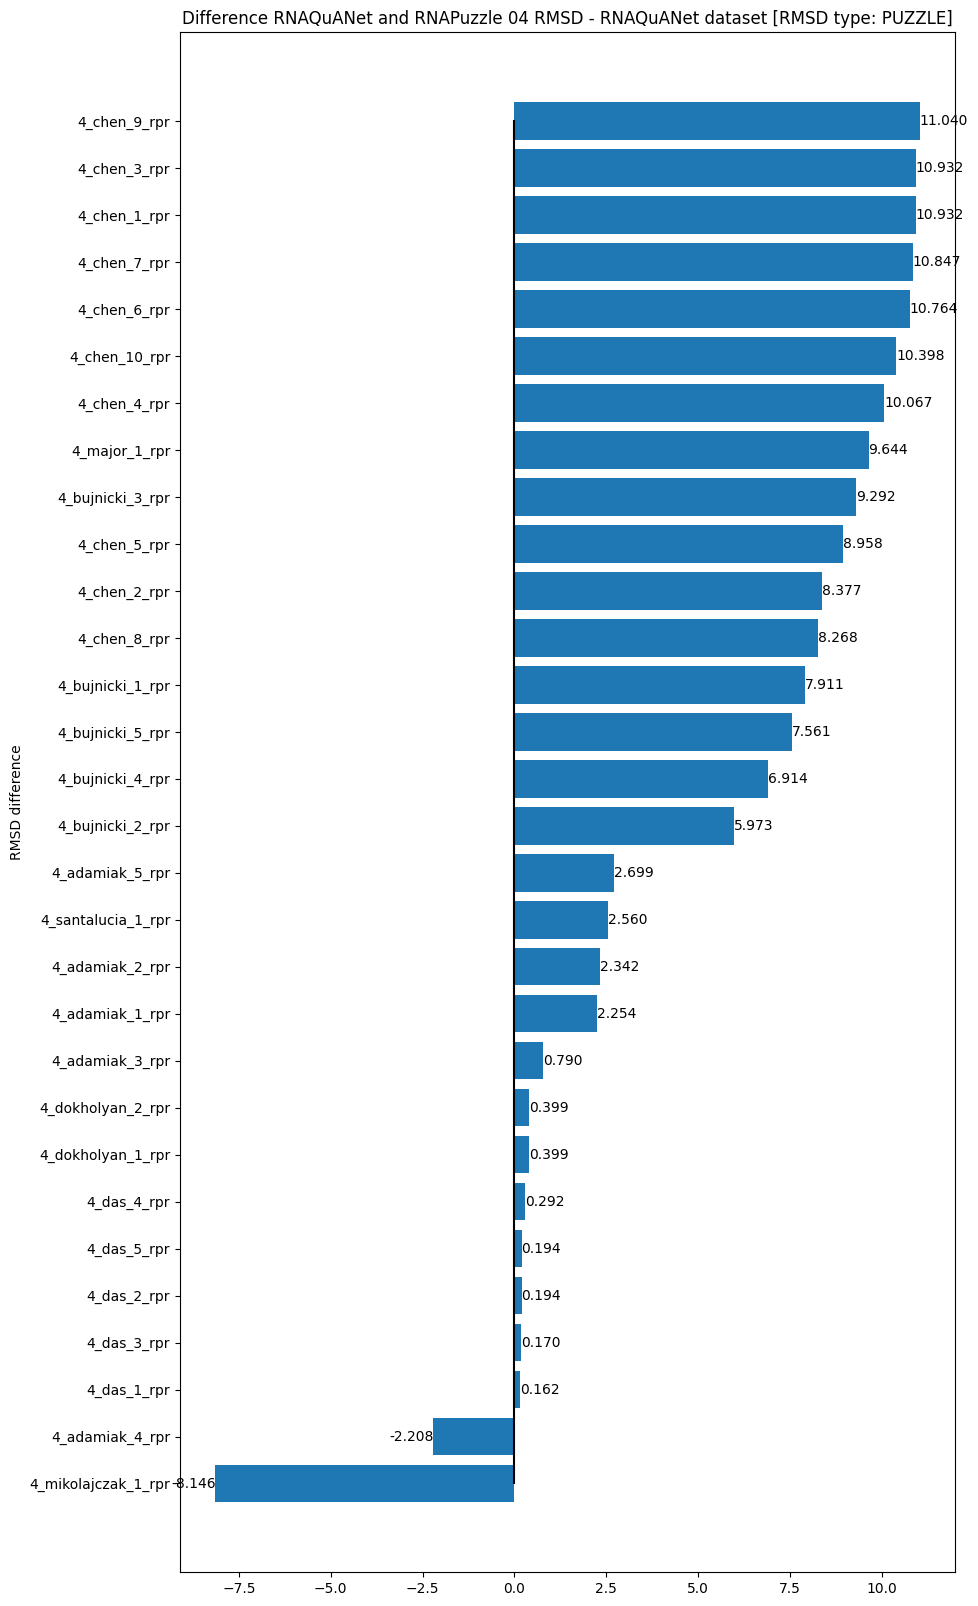

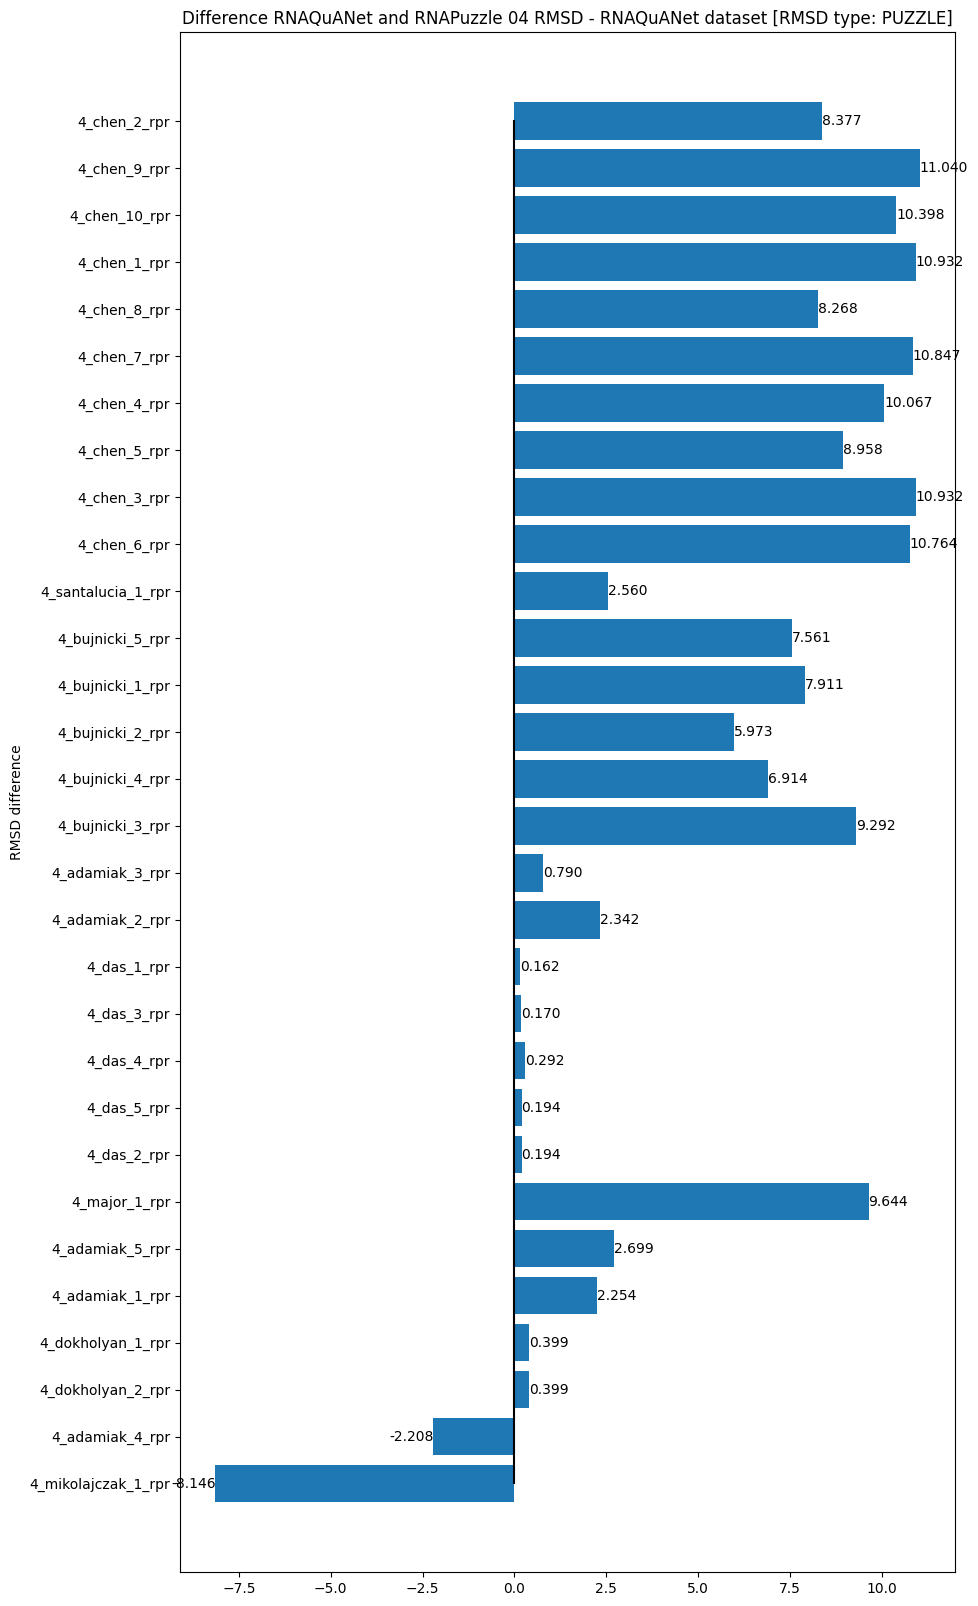

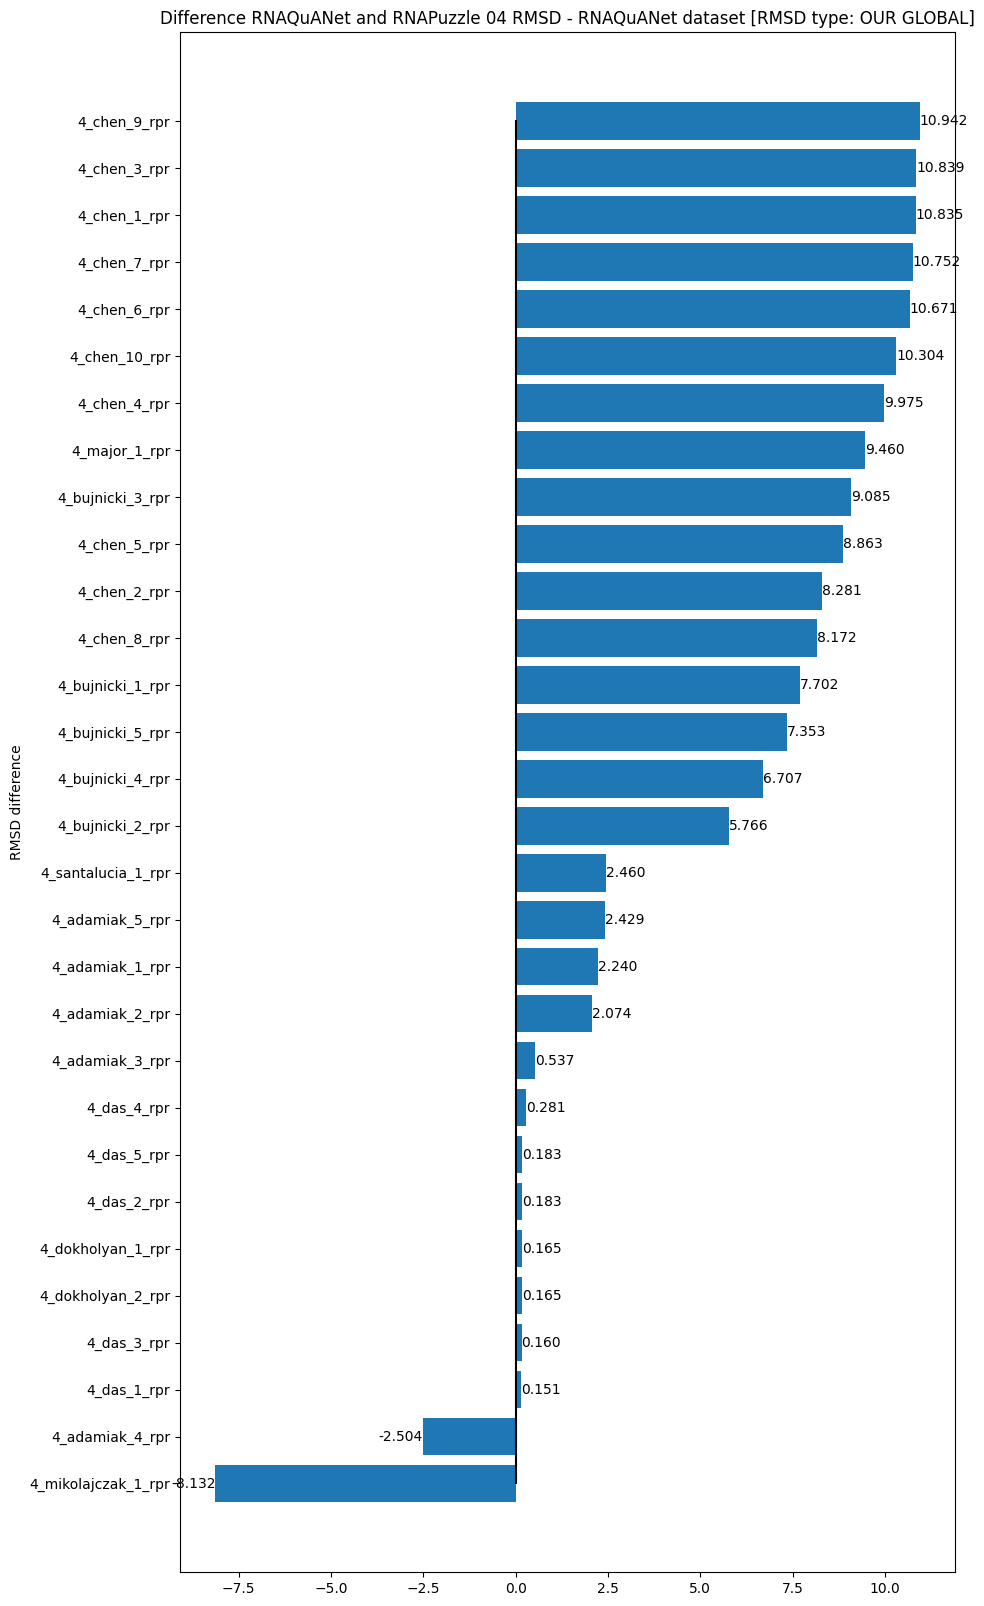

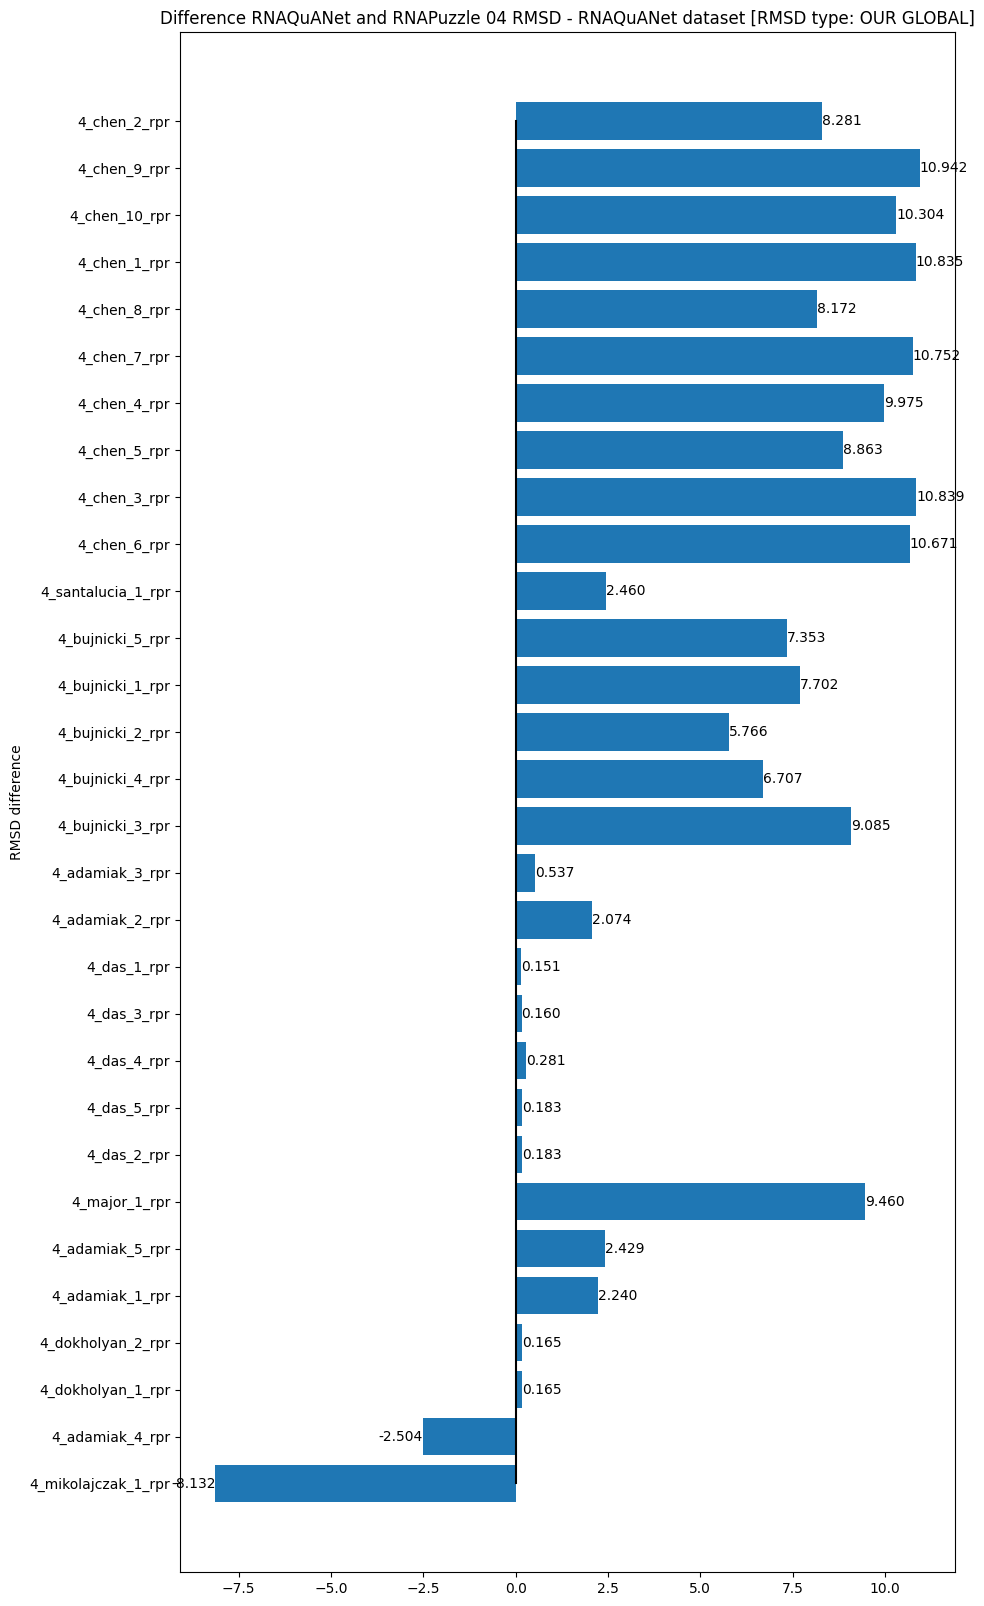

In [45]:
import matplotlib.pyplot as plt
trained_on = dataset
for by in ['diff','true_rmsd_global_diff']:
# Sample data
    match by:
        case 'diff':
            by_name='PUZZLE'
        case 'true_rmsd_global_diff':
            by_name='OUR GLOBAL'
        case 'true_rmsd_C5prim_diff':
            by_name='OUR C5\''
    
    result=result.sort_values(by=by).reset_index(drop=True)
    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 20))

    # Plot bars
    bars = ax.barh(result['Name'], result[by], capsize=5)

    # Rotate the y-axis data series by 90 degrees

    # Set labels
    # plt.xticks(rotation=90)
    ax.set_ylabel('RMSD difference')
    ax.plot( [0]*len(result['Name']),result['Name'], linestyle='solid', linewidth=1.5, color='black')
    ax.set_title(f'Difference RNAQuANet and RNAPuzzle 04 RMSD - {trained_on} dataset [RMSD type: {by_name}]')
    for i in range(len(result['Name'])):
        if result[by][i]<0:
            ax.text(result[by][i]-1.2,i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
        else:
            ax.text(result[by][i],i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
    # Show plot
    plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle04_compare/{trained_on}_{by}.svg')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    result=result.sort_values(by='true_rmsd_global',ascending=False).reset_index(drop=True)
    # Plot bars
    bars = ax.barh(result['Name'], result[by], capsize=5)

    # Rotate the y-axis data series by 90 degrees

    # Set labels
    # plt.xticks(rotation=90)
    ax.set_ylabel('RMSD difference')
    ax.plot( [0]*len(result['Name']),result['Name'], linestyle='solid', linewidth=1.5, color='black')
    ax.set_title(f'Difference RNAQuANet and RNAPuzzle 04 RMSD - {trained_on} dataset [RMSD type: {by_name}]')
    for i in range(len(result['Name'])):
        if result[by][i]<0:
            ax.text(result[by][i]-1.2,i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
        else:
            ax.text(result[by][i],i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
    # Show plot
    plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle04_compare/{trained_on}_{by}_ordered.svg')
    plt.show()

In [40]:
import scipy.stats as stats

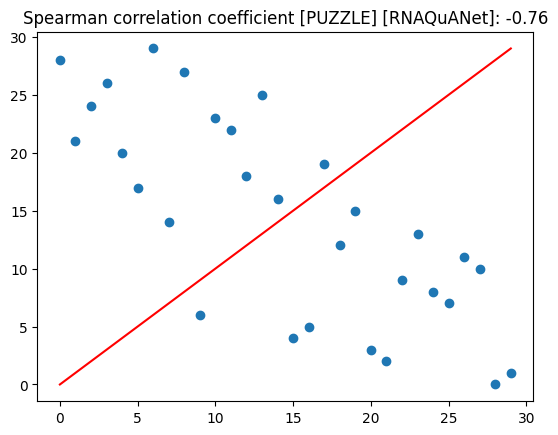

In [41]:
rmsd_sorted = result.sort_values(by='RMSD').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_puzzle']=abs(rmsd_sorted-error_sorted)

plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [PUZZLE] [{:s}]: {:.2f}".format(dataset,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{dataset}_PUZZLE_spearman.svg')

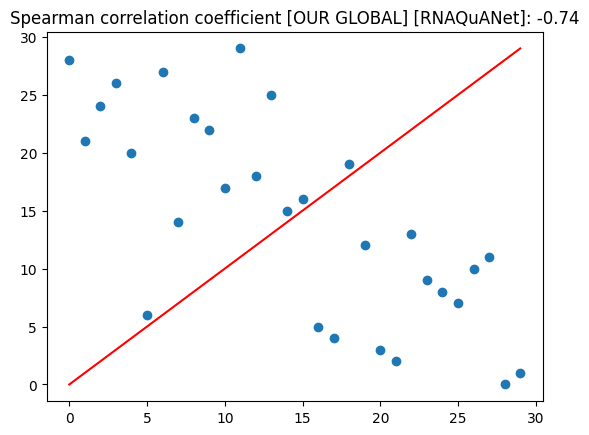

In [42]:
rmsd_sorted = result.sort_values(by='true_rmsd_global').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_global']=(rmsd_sorted-error_sorted)
plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [OUR GLOBAL] [{:s}]: {:.2f}".format(dataset,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{dataset}_GLOBAL_spearman.svg')

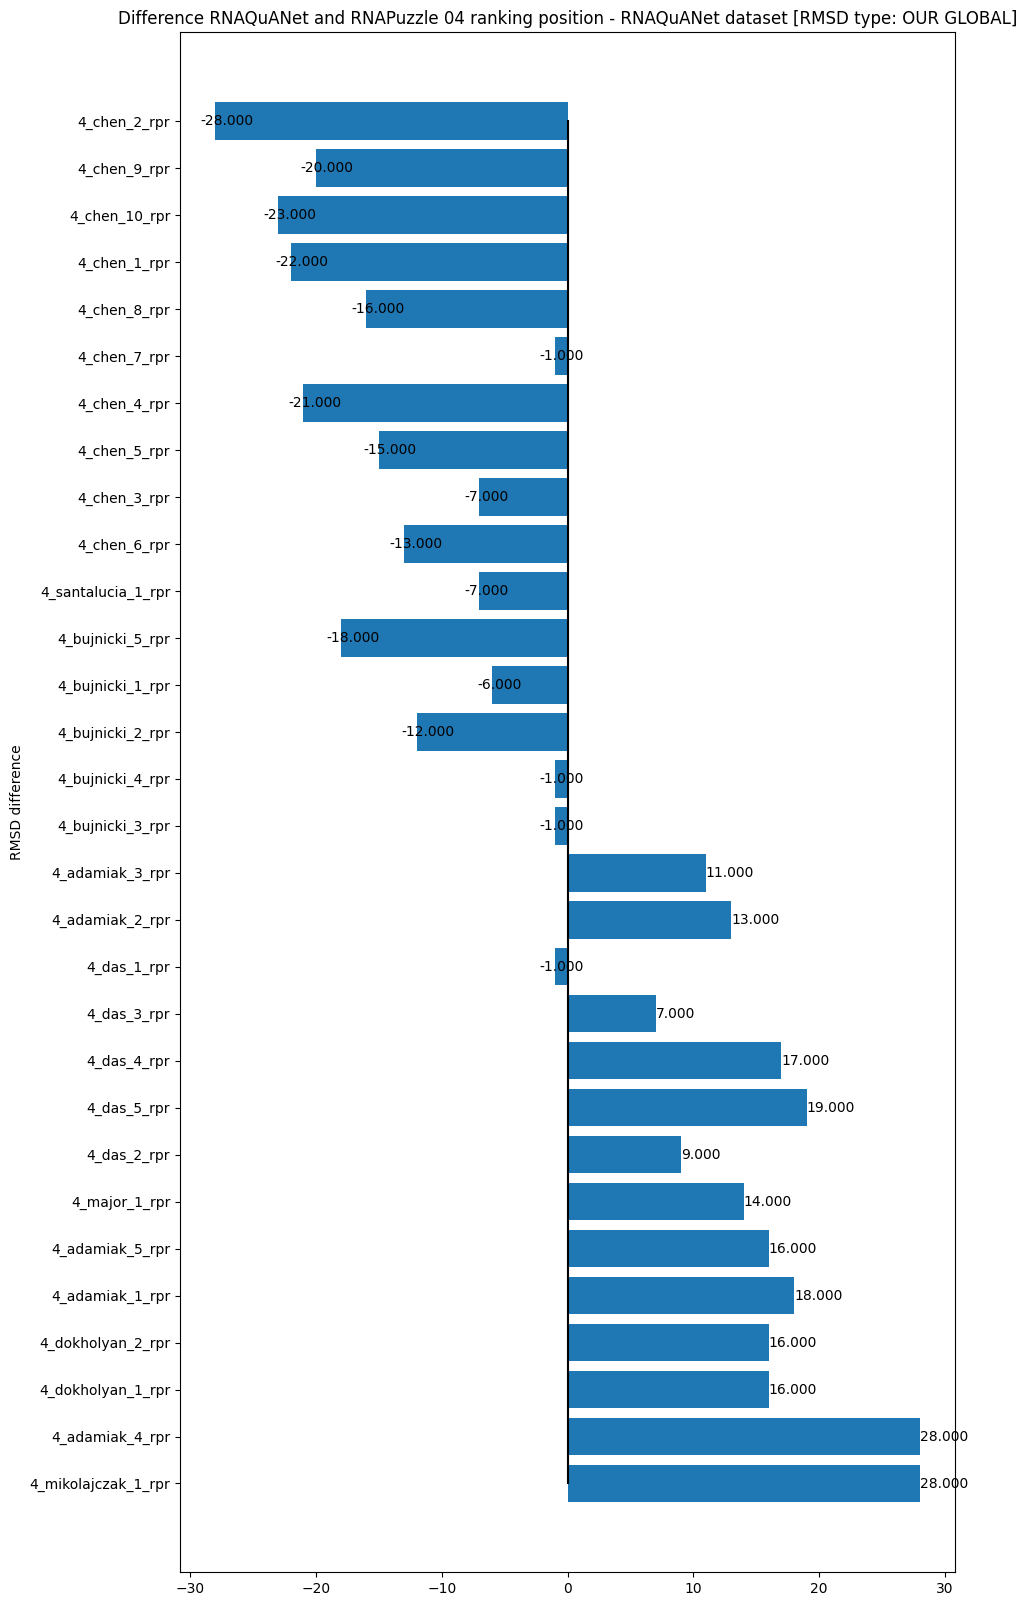

In [43]:
fig, ax = plt.subplots(figsize=(10, 20))
# Plot bars
by='spearman_distance_global'
result=result.sort_values(by='true_rmsd_global',ascending=False).reset_index(drop=True)
bars = ax.barh(result['Name'], result[by], capsize=5)

# Rotate the y-axis data series by 90 degrees

# Set labels
# plt.xticks(rotation=90)
ax.set_ylabel('RMSD difference')
ax.plot( [0]*len(result['Name']),result['Name'], linestyle='solid', linewidth=1.5, color='black')
ax.set_title(f'Difference RNAQuANet and RNAPuzzle 04 ranking position - {trained_on} dataset [RMSD type: {by_name}]')
for i in range(len(result['Name'])):
    if result[by][i]<0:
        ax.text(result[by][i]-1.2,i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
    else:
        ax.text(result[by][i],i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')

In [65]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_global_diff','spearman_distance_puzzle','spearman_distance_global']].to_csv(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/PZ38r_{dataset}.csv',index=False)

In [66]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_global_diff','spearman_distance_puzzle','spearman_distance_global']]

,Name,error,RMSD,diff,true_rmsd_global,true_rmsd_global_diff,spearman_distance_puzzle,spearman_distance_global
0,PZ38_Ding_5,3.575051,23.044,-19.468949,22.909023,-19.333972,66,66
1,PZ38_Xiao_2,2.018843,19.748,-17.729157,19.612543,-17.593700,0,0
2,PZ38_Xiao_3,1.935676,18.316,-16.380324,18.231400,-16.295723,53,53
3,PZ38_Xiao_1,1.730903,18.089,-16.358097,17.968151,-16.237248,3,3
4,PZ38_Dfold_3,4.555131,19.824,-15.268869,19.691608,-15.136477,69,69
...,...,...,...,...,...,...,...,...
69,PZ38_Chen_3,2.219241,7.978,-5.758759,8.016673,-5.797432,66,66
70,PZ38_Dfold_4,8.299161,13.387,-5.087839,13.324327,-5.025166,67,67
71,PZ38_Szachniuk_1,3.532975,8.394,-4.861025,8.474765,-4.941790,0,0
72,PZ38_YangServer_4,9.418735,12.453,-3.034265,12.631305,-3.212570,0,0
